In [78]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("XLSX")
Pkg.add("CSV")


  Activating project at `~/Desktop/BEE 4750/BEE4750FinalProject-1`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`


In [79]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using XLSX
using CSV

Load Data for all buildings

In [ ]:
using CSV, DataFrames

# Read the CSV file into a DataFrame
df = CSV.read("HuShihHall.csv", DataFrame)
date = df."Date"[1:366]
hushih_chilled_water = df."Chilled Water (tons)"[1:366]
hushih_hot_water     = df."Hot Water (kBTU/hr)"[1:366]
hushih_electric      = df."Electric (kW)"[1:366]

df = CSV.read("CascadillaHall.csv", DataFrame)
date = df."Date"[1:366]
casc_hot_water     = df."Steam (lbs/hr)"[1:366]
casc_electric      = df."Electric (kW)"[1:366]




366-element Vector{Union{Missing, Float64}}:
 29.868258437
 44.901883437
 37.199118333
 39.957539062
 49.754995
 49.725438958
 49.139926666
 49.018503125
 41.25201375
 40.332536458
  ⋮
 55.119526304
 55.812191979
 55.885507263
 55.977669062
 39.243125937
 49.716806421
 42.377715157
 35.736475729
 53.242477395

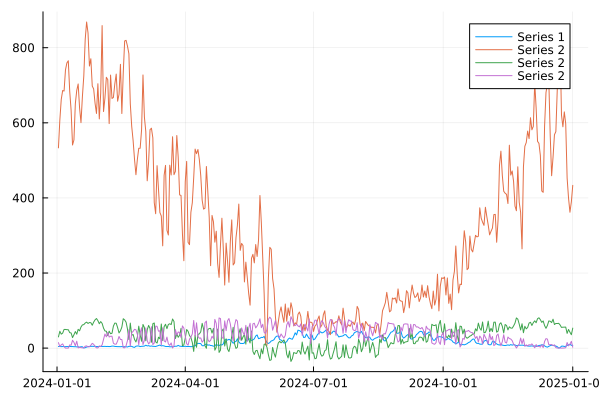

In [81]:
# Start the first plot and store it in a variable 'p'
p = plot(date, hushih_chilled_water, label="Series 1")

# Add the second line to the existing plot 'p' using plot!()
plot!(p, date, hushih_hot_water, label="Series 2")
plot!(p, date, hushih_electric, label="Series 2")
plot!(p, date, hushih_solar, label="Series 2")

# Display the final plot
display(p)